# DSE 207R FINAL PROJECT - Raghav Vasappanavara

# Impact of Tariffs on Consumer Price Index in US.

Objective:
Examine the relationship between tariff rates and the Consumer Price Index (CPI) over the last 8 years.
Establish whether changes in tariff data have led to observable patterns or increases in CPI.



## Fall 2024
### Due Date:  December 10th, 2024

The final project is a guided project for you to build your own end-to-end analysis using Python, especially using what you learned on Python _numpy_, _pandas_, _matplotlib_/_seaborn_ and _scilitlearn_ libraries.

This project is culmination of all you’ve learned in this course! You should expect to spend <b>24-32 total hours</b> on the project. Be sure to read all of the items below before starting. Make sure to follow Slack for any updates on the final project.

# <b>Deliverables</b>:
The final project has 2 submissions - a report (this notebook) and an presentation video (self recorded). You will be evaluated on both the components.

## 1. Report (this notebook)
Submit the notebook via Gradescope by midnight on the due date above along with clear instructions on how to download the datasets you used for and reproduce your results. You can host the dataset (on GitHub) such that it can be used as a URL directly. Don't forget to add your name on top as the author of the notebook.



There are a number of steps outlined below, but is critical that you do not view this as an entirely linear process.  Remember that the science component in data science is the creation of a hypothesis based on exploration and testing of that hypothesis through analysis.  You may need to go through many of these steps multiple times before you arrive at meaningful hypothesis or conclusions.

# Step 1: Dataset Description

The datasets cpi_df, tariff_df, and final_tariff_mean_df provide comprehensive information on consumer prices and tariff rates over multiple years. These datasets include crucial metrics like the Consumer Price Index (CPI) percentage change and the Most-Favored-Nation (MFN) text rates, segmented by various expenditure categories.
# Data Sources and Acknowledgment:

* https://dataweb.usitc.gov/tariff/annual
* https://www.bls.gov/cpi/data.htm
* Instructor training materials, guides for various implementations
* google/stack overflow/github for various code iplementation examples on nlp, sentence transformation.

# Key Components:

* cpi_df: Contains CPI percentage changes for various expenditure categories over the years, reflecting inflationary trends and consumer price fluctuations.

* tariff_df: Details MFN text rates applied to different expenditure categories, indicating the tariff rates imposed on imports for those categories.

* final_tariff_mean_df: Averages MFN text rates across different categories, providing a broader overview of the tariff landscape.

# Hardware : GPU T4 available as part of trial usage for sentence transformation in collab.

# Goal of Analysis through this Dataset:

Analysis on these datasets aim to convey the dynamic interplay between tariff policies and consumer prices. By analyzing these datasets, we can gain insights into:

    1. Economic Impact: How changes in tariff rates influence consumer prices for specific categories, such as motor vehicles, hardware, and parts.

    2. Sector Sensitivity: Identifying which categories are more susceptible to tariff changes, providing insights for policymakers and businesses.
    
    3. Temporal Trends: Observing patterns and shifts in tariff rates and CPI changes over time, helping to forecast future economic conditions and make informed policy decisions.


# Data Ingestion, Cleanup and Processing for Analysis

In [ ]:
#Run this cell for all the imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re  # Regular expressions
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import plotly.express as px


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Read the data
1. Read CPI data into CPI DF associated with that year.
2. Read Tariff data into Tariff DF associated with that year.

In [ ]:
def load_csv_cpi(url, year):
    """
    Reads a CPI CSV file from a URL and returns a cleaned DataFrame.
    Starts parsing rows from the row where the first column is "Indent Level"
    and the second column is "Expenditure category". Continues while the first column is not null.
    Adds 'Year' as the first column and removes empty rows.

    Args:
        url (str): The URL of the CPI CSV file.
        year (int): The year to be added as a column.

    Returns:
        pd.DataFrame: The loaded and cleaned CPI DataFrame.
    """
    try:
        # Load the entire CSV file
        df = pd.read_csv(url, encoding='ISO-8859-1', low_memory=False)

        # Check if the DataFrame is empty
        if df.empty:
            print(f"Error: The file at {url} is empty.")
            return None

        # Find the starting row ("Indent Level" and "Expenditure category")
        start_row = df[(df.iloc[:, 0].str.contains("Indent Level", na=False)) &
                       (df.iloc[:, 1].str.contains("Expenditure category", na=False))].index
        if start_row.empty:
            print(f"Error: 'Indent Level' with 'Expenditure category' not found in {url}.")
            return None
        start_row = start_row[0]

        # Subset the DataFrame from start_row onwards
        df = df.iloc[start_row:].reset_index(drop=True)

        # Use the row at 'start_row' as column names
        df.columns = df.iloc[0]

        # Remove the row with column names
        df = df.iloc[1:]

        # Continue parsing only while the first column is not null
        df = df[df.iloc[:, 0].notna()].reset_index(drop=True)

        # Add the 'Year' column as the first column
        df['Year'] = year
        df = df[['Year'] + [col for col in df.columns if col != 'Year']]

        return df
    except Exception as e:
        print(f"Error loading CPI CSV file {url}: {e}")
        return None


def load_csv_tariff(url, year):
    """
    Reads a Tariff CSV file from a URL and returns a cleaned DataFrame.
    Adds 'Year' as the first column and removes empty rows.

    Args:
        url (str): The URL of the Tariff CSV file.
        year (int): The year to be added as a column.

    Returns:
        pd.DataFrame: The loaded Tariff DataFrame.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(url, encoding='ISO-8859-1', low_memory=False)

        # Remove empty rows
        df = df.dropna(how='all')

        # Add the 'Year' column as the first column
        df['Year'] = year
        df = df[['Year'] + [col for col in df.columns if col != 'Year']]

        return df
    except Exception as e:
        print(f"Error loading Tariff CSV file {url}: {e}")
        return None


# URLs for the CPI CSV files
cpi_urls = [
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-201710.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-201810.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-201910.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-202010.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-202110.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-202210.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-202310.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/cpi-u-202410.csv"
]

# URLs for the Tariff CSV files
tariff_urls = [
    "https://github.com/rvasappa/dsc207r/raw/main/trade_tariff_database_202405.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/trade_tariff_database_202307.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/tariff_database_text_version_202207.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/tariff_database_text_version_202106.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/tariff_database_text_version_202010.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/trade_tariff_database_201911.txt",
    "https://github.com/rvasappa/dsc207r/raw/main/tariff_database_2018.csv",
    "https://github.com/rvasappa/dsc207r/raw/main/tariff_database_2017.txt"
]

# Extract years from filenames
cpi_years = [int(url.split('-')[-1].split('.')[0][:4]) for url in cpi_urls]
tariff_years = [int(url.split('_')[-1].split('.')[0][:4]) for url in tariff_urls]

# Load CPI CSV files into DataFrames and append 'Year' column
cpi_dfs = {f"df_cpi_{year}": load_csv_cpi(url, year) for url, year in zip(cpi_urls, cpi_years)}

# Load Tariff CSV files into DataFrames and append 'Year' column
tariff_dfs = {f"df_tariff_{year}": load_csv_tariff(url, year) for url, year in zip(tariff_urls, tariff_years)}

# Print shapes and heads of CPI DataFrames
print("\nCPI DataFrames:")
for name, df in cpi_dfs.items():
    if df is not None:
        print(f"\n{name}:")
        print(f"Shape: {df.shape}")
    else:
        print(f"{name}: DataFrame is None")

# Print shapes and heads of Tariff DataFrames
print("\nTariff DataFrames:")
for name, df in tariff_dfs.items():
    if df is not None:
        print(f"\n{name}:")
        print(f"Shape: {df.shape}")
    else:
        print(f"{name}: DataFrame is None")




CPI DataFrames:

df_cpi_2017:
Shape: (393, 1235)

df_cpi_2018:
Shape: (393, 1235)

df_cpi_2019:
Shape: (393, 1235)

df_cpi_2020:
Shape: (393, 1235)

df_cpi_2021:
Shape: (383, 1235)

df_cpi_2022:
Shape: (383, 399)

df_cpi_2023:
Shape: (383, 399)

df_cpi_2024:
Shape: (383, 399)

Tariff DataFrames:

df_tariff_2024:
Shape: (12975, 123)

df_tariff_2023:
Shape: (13102, 123)

df_tariff_2022:
Shape: (13826, 123)

df_tariff_2021:
Shape: (13066, 123)

df_tariff_2020:
Shape: (22438, 123)

df_tariff_2019:
Shape: (14819, 113)

df_tariff_2018:
Shape: (13200, 113)

df_tariff_2017:
Shape: (12861, 113)


Data Clean up for CPI DF.
1. Removed all indices, since we are interested in tracking year to year % change across various consumer categories.
2. merged all cpi DF into one single DF.
---



In [ ]:
def transform_cpi_df(cpi_df):
    """
    Transforms the CPI DataFrame to contain only the first four columns: 'Year', 'Indent Level',
    'Expenditure Category', and 'CPI Percentage Change'.

    Args:
        cpi_df (pd.DataFrame): The CPI DataFrame to modify.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    # Get the current last column name
    last_column_name = cpi_df.columns[-1]

    # Rename the last column to 'CPI Percentage Change'
    cpi_df = cpi_df.rename(columns={last_column_name: "CPI Percentage Change"})

    # Select only the desired columns
    cpi_df = cpi_df.iloc[:, [0, 1, 2, -1]]

    return cpi_df

# Apply the transformation function to each CPI DataFrame and print the head
for name, df in cpi_dfs.items():
    if df is not None:
        cpi_dfs[name] = transform_cpi_df(df)
        print(f"\n{name} (after transformation):")
        print(cpi_dfs[name].head())
    else:
        print(f"{name}: DataFrame is None")

# Combine all transformed CPI DataFrames into a single DataFrame
cpi_df = pd.concat(cpi_dfs.values(), ignore_index=True)

# Print the shape and head of the combined DataFrame
print("\nCombined CPI DataFrame (cpi_df_transform):")
print(f"Shape: {cpi_df.shape}")





df_cpi_2017 (after transformation):
0  Year Indent Level         Expenditure category CPI Percentage Change
0  2017            0                    All items                   1.9
1  2017            1                         Food                   1.3
2  2017            2                 Food at home                   0.7
3  2017            3  Cereals and bakery products                  -0.8
4  2017            4  Cereals and cereal products                  -2.2

df_cpi_2018 (after transformation):
0  Year Indent Level         Expenditure category CPI Percentage Change
0  2018            0                    All items                   2.7
1  2018            1                         Food                   1.2
2  2018            2                 Food at home                   0.1
3  2018            3  Cereals and bakery products                   0.3
4  2018            4  Cereals and cereal products                  -1.3

df_cpi_2019 (after transformation):
0  Year Indent Level     

In [ ]:
def transform_tariff_df(tariff_df):
    """
    Transforms the Tariff DataFrame to contain only the specified columns:
    'Year', 'hts8', 'brief_description', 'mfn_text_rate', and 'mfn_ad_val_rate'.

    Args:
        tariff_df (pd.DataFrame): The Tariff DataFrame to modify.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    # Select only the desired columns
    columns_to_keep = ['Year', 'hts8', 'brief_description', 'mfn_text_rate', 'mfn_ad_val_rate']
    tariff_df = tariff_df[columns_to_keep]

    return tariff_df

# Apply the transformation function to each Tariff DataFrame and print the head
for name, df in tariff_dfs.items():
    if df is not None:
        tariff_dfs[name] = transform_tariff_df(df)
        print(f"\n{name} (after transformation):")
        print(tariff_dfs[name].head())
    else:
        print(f"{name}: DataFrame is None")

# Combine all transformed Tariff DataFrames into a single DataFrame
tariff_df = pd.concat(tariff_dfs.values(), ignore_index=True)

# Print the shape and head of the combined DataFrame
print("\nCombined Tariff DataFrame (tariff_df_transform):")
print(f"Shape: {tariff_df.shape}")





df_tariff_2024 (after transformation):
   Year     hts8                                  brief_description  \
0  2024  1012100                      Live purebred breeding horses   
1  2024  1012900    Live horses other than purebred breeding horses   
2  2024  1013000                                         Live asses   
3  2024  1019030  Mules and hinnies imported for immediate slaug...   
4  2024  1019040  Mules and hinnies not imported for immediate s...   

  mfn_text_rate  mfn_ad_val_rate  
0          Free            0.000  
1          Free            0.000  
2          6.8%            0.068  
3          Free            0.000  
4          4.5%            0.045  

df_tariff_2023 (after transformation):
   Year      hts8                                  brief_description  \
0  2023  55031910  Synthetic staple fibers, n/carded, combed or o...   
1  2023  99080403  Eligible products of Israel provided for in su...   
2  2023  41071110  Full grain unsplit whole bovine upper or linin..


# From above transformations and cleanup, we have two dataframes, one for hosting cpi increases for expenditure category and other one for hosting tariffs which is a much broader table for last 8 years. Main challenge here is to create a new data pattern where we are trying to establish an emphirical relationship between cpi price inreases and tariff data.


## We will use NLP to match the brief_description_category in the Tariff DataFrame to the Expenditure Category in the CPI DataFrame by understanding the semantic similarity for broader context of the descriptions.

Matching Algorithm Approach:

* Preprocess the Text:
  * Apply normalization, tokenization to both the brief_description_category and Expenditure Category.

* Generate Sentence Embeddings:

 * Use a pre-trained sentence embedding model like SentenceTransformers (e.g., all-MiniLM-L6-v2) to generate embeddings for:
   * Each row in brief_description_category.
   * Each unique category in Expenditure Category.

* Match Descriptions to Categories:

 * Compute the cosine similarity between the embeddings of tariff descriptions and expenditure categories.
 * Assign each description to the category with the highest similarity score.
Output Mapped Results:

 * Append the matched Expenditure Category to the Tariff DataFrame for each row.




# Implementation Steps for aligning tariff df names with cpi df names:

1. Text Preprocessing : Clean and standardize text by converting to lowercase and removing special characters while preserving alphanumeric and percentage symbols.

2. Detect and Correct Incomplete Descriptions : Correct known incomplete descriptions to their intended complete forms using a dictionary of corrections.


3. Custom Classification : Indentify categories that dont match cleanly and apply custom mapping to know good embedding.

4. Filter Rows with Valid Percentages : Filter rows where mfn_text_rate contains valid percentage values.

5. Data Cleaning and Preprocessing : Apply text preprocessing and filtering functions to clean and standardize the data.

6. Sentence Transformer Initialization : Initialize a pre-trained Sentence Transformer model to compute text embeddings for Expenditure category and brief_description.

7. Cosine Similarity Calculation : Compute the cosine similarity between tariff descriptions and expenditure categories to find the best matches.

8. Matching Descriptions to Categories : Match each description to the closest expenditure category using custom classifications, mappings, and cosine similarity.

9. Update DataFrame and Save Results


In [ ]:
# Preprocessing function
def preprocess_text(text):
    """
    Preprocesses text while preserving original terms and structure.
    """
    if pd.isna(text):
        return ''
    # Convert text to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s%]', '', text)  # Retain only alphanumeric and percentage symbols
    return text.strip()

# Detect and correct incomplete descriptions
def detect_incomplete_descriptions(description):
    corrections = {
        "live a": "live ass",
        "live fox": "live animal fox",
        "live bird": "live bird of prey",
        "ostrich emu": "ostrich and emu",
    }
    return corrections.get(description, description)

# Custom classification for Tools and Hardware
def classify_tools_and_hardware(description):
    tools_keywords = [
        "machinery", "mold", "valve", "robot", "compressor", "press", "tool", "hardware",
        "screw", "bolt", "metal foundry", "mechanical", "hydraulic"
    ]
    for keyword in tools_keywords:
        if keyword in description:
            return "Tools, hardware and supplies(5)"
    return None

# Retain all existing custom mappings
custom_mappings = {
    # Energy
    "gasoline": "Gasoline (all types)",
    "diesel": "Motor fuel",
    "fuel oil": "Fuel oil",
    "propane": "Energy commodities",
    "kerosene": "Energy commodities",
    "electricity": "Electricity",
    "utility gas": "Utility (piped) gas service",
    "natural gas": "Utility (piped) gas service",

    # Food
    "meat": "Meats, poultry, and fish",
    "cheese": "Dairy and related products",
    "milk": "Dairy and related products",
    "beverages": "Beverages",

    # Tools and Hardware
    "mold": "Tools, hardware and supplies(5)",
    "valve": "Tools, hardware and supplies(5)",
    "robot": "Tools, hardware and supplies(5)",
    "compressor": "Tools, hardware and supplies(5)",
    "tool": "Tools, hardware and supplies(5)",
    "hydraulic": "Tools, hardware and supplies(5)",

    # Animals and Birds
    "live": "Pets and pet products(4)",
    "bird": "Pets and pet products(4)",
    "ostrich": "Pets and pet products(4)",
    "emu": "Pets and pet products(4)",
    "fox": "Pets and pet products(4)",
    "cow": "Pets and pet products(4)"
}

def apply_custom_mapping(description, mappings):
    """
    Matches a description using custom rules.
    """
    for keyword, category in mappings.items():
        if keyword in description:
            return category
    return None

# Function to filter rows with valid percentages in `mfn_text_rate`
def filter_percentage_rates(rate):
    """
    Checks if the rate contains a valid percentage.
    """
    if pd.isna(rate):
        return False
    rate = rate.strip()
    return bool(re.match(r'^\d+(\.\d+)?%$', rate))


# Detect and correct incomplete descriptions
tariff_df['brief_description'] = tariff_df['brief_description'].apply(detect_incomplete_descriptions)

# Preprocess the descriptions in the tariff dataset
tariff_df['brief_description'] = tariff_df['brief_description'].apply(preprocess_text)

# Filter rows where `mfn_text_rate` contains valid percentages
tariff_df = tariff_df[tariff_df['mfn_text_rate'].apply(filter_percentage_rates)]

# Preprocess expenditure categories (assume `cpi_df` is already available)
cpi_df['Expenditure category'] = cpi_df['Expenditure category'].apply(preprocess_text)

# Initialize SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Precompute embeddings for expenditure categories
unique_expenditures = cpi_df['Expenditure category'].unique()
expenditure_embeddings = model.encode(unique_expenditures, batch_size=128)

# Compute embeddings for tariff descriptions in batches
tariff_embeddings = model.encode(tariff_df['brief_description'].tolist(), batch_size=128)

# Compute cosine similarity in bulk
similarity_matrix = cosine_similarity(tariff_embeddings, expenditure_embeddings)

# Match descriptions to the closest expenditure category
matched_categories = []
for i, description in enumerate(tariff_df['brief_description']):
    # Apply custom classifications first
    tool_category = classify_tools_and_hardware(description)
    if tool_category:
        matched_categories.append(tool_category)
        continue

    # Apply custom mappings
    custom_match = apply_custom_mapping(description, custom_mappings)
    if custom_match:
        matched_categories.append(custom_match)
        continue

    # Use cosine similarity as fallback
    best_match_idx = similarity_matrix[i].argmax()
    best_similarity = similarity_matrix[i][best_match_idx]

    # Use lower threshold to allow more matches
    if best_similarity >= 0.5:  # Relaxed threshold
        matched_categories.append(unique_expenditures[best_match_idx])
    else:
        matched_categories.append("Unmatched")

# Add matched categories to the DataFrame
tariff_df['Matched Expenditure category'] = matched_categories

# Remove unmatched rows
tariff_df = tariff_df[tariff_df['Matched Expenditure category'] != "Unmatched"]

# Save the filtered and updated dataset
output_file = 'final_tariff_df_filtered.csv'
tariff_df.to_csv(output_file, index=False)

# Download and manually review matched categories
from google.colab import files
files.download(output_file)

# Display the first few rows of the updated DataFrame
print(tariff_df[['brief_description', 'mfn_text_rate', 'Matched Expenditure category']].head())
print(tariff_df.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                                    brief_description mfn_text_rate  \
2                                          live asses          6.8%   
27                                         live foxes          4.8%   
30                                 live birds of prey          1.8%   
31  live psittaciforme birds including parrots par...          1.8%   
32                                     ostriches emus          1.8%   

   Matched Expenditure category  
2      Pets and pet products(4)  
27     Pets and pet products(4)  
30     Pets and pet products(4)  
31     Pets and pet products(4)  
32     Pets and pet products(4)  
(16329, 6)


Matching Accuracy for the above technique is visually parsed and displayed:

https://raw.githubusercontent.com/rvasappa/dsc207r/refs/heads/main/final_tariff_df_filtered.csv

Main thing to note would be look at Brief Description and Expenditure Category for semantic similarity.


# Process tariff df, take mean for each unique expenditure category.
# Interpose CPI Percentage Change in this df from cpi_df.

In [ ]:
def calculate_uniform_mean_rates_with_cpi(tariff_df, cpi_df):
    """
    Ensures uniform expenditure categories across all years, calculates mean rates,
    and adds CPI percentage change for each expenditure category.
    Filters out rows where CPI percentage change is not a valid number.
    """
    # Ensure 'mfn_text_rate' and 'mfn_ad_val_rate' are numeric
    tariff_df['mfn_text_rate'] = tariff_df['mfn_text_rate'].astype(str).str.rstrip('%').astype(float)
    tariff_df['mfn_ad_val_rate'] = tariff_df['mfn_ad_val_rate'].astype(float)

    # Identify uniform expenditure categories across all years
    unique_categories_by_year = tariff_df.groupby('Year')['Matched Expenditure category'].apply(set)
    uniform_categories = set.intersection(*unique_categories_by_year)

    # Filter the DataFrame for only the uniform expenditure categories
    tariff_df_filtered = tariff_df[tariff_df['Matched Expenditure category'].isin(uniform_categories)]

    # Group by Year and Expenditure Category to calculate mean rates
    tariff_mean_df = (
        tariff_df_filtered.groupby(['Year', 'Matched Expenditure category'])
        .agg(
            mfn_text_rate_mean=('mfn_text_rate', 'mean'),
            mfn_ad_val_rate_mean=('mfn_ad_val_rate', 'mean')
        )
        .reset_index()
    )

    # Rename columns for clarity
    tariff_mean_df.rename(
        columns={
            'Matched Expenditure category': 'expenditure_category',
        },
        inplace=True
    )

    # Round mean values to 2 decimal places
    tariff_mean_df['mfn_text_rate_mean'] = tariff_mean_df['mfn_text_rate_mean'].round(2)
    tariff_mean_df['mfn_ad_val_rate_mean'] = tariff_mean_df['mfn_ad_val_rate_mean'].round(2)

    # Match CPI data and add CPI percentage change
    # Normalize expenditure categories for matching
    tariff_mean_df['expenditure_category'] = tariff_mean_df['expenditure_category'].str.lower()
    cpi_df['Expenditure category'] = cpi_df['Expenditure category'].str.lower()

    # Filter CPI data to keep only rows with numeric CPI percentage change
    cpi_df = cpi_df[pd.to_numeric(cpi_df['CPI Percentage Change'], errors='coerce').notna()]

    # Create a mapping from CPI expenditure category to CPI percentage change
    cpi_mapping = cpi_df.set_index('Expenditure category')['CPI Percentage Change'].to_dict()

    # Add CPI percentage change to the DataFrame
    tariff_mean_df['cpi_percentage_change'] = tariff_mean_df['expenditure_category'].map(cpi_mapping)

    # Drop rows where CPI percentage change is missing
    tariff_mean_df = tariff_mean_df.dropna(subset=['cpi_percentage_change'])

    return tariff_mean_df

# Call the function with the provided tariff_df and cpi_df
final_tariff_mean_df = calculate_uniform_mean_rates_with_cpi(tariff_df, cpi_df)

# Save the filtered and updated dataset
output_file = 'uniform_mean_tariff_with_cpi_filtered.csv'
final_tariff_mean_df.to_csv(output_file, index=False)

# Download and manually review matched categories
from google.colab import files
files.download(output_file)

# Display the first few rows of the resulting DataFrame and its shape
print(final_tariff_mean_df.head())
print("Shape of final_tariff_mean_df:", final_tariff_mean_df.shape)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

    Year        expenditure_category  mfn_text_rate_mean  \
1   2017  dairy and related products               12.02   
2   2017                 electricity                3.50   
3   2017          energy commodities                4.88   
6   2017                  motor fuel                2.87   
10  2017         alcoholic beverages                5.50   

    mfn_ad_val_rate_mean cpi_percentage_change  
1                   0.12                   1.3  
2                   0.03                   4.9  
3                   0.04                 -10.1  
6                   0.03                 -10.4  
10                  0.05                   1.9  
Shape of final_tariff_mean_df: (1408, 5)


# Step 2: Data Exploration






1. Top Expenditure Categories by Mean Tariff Rates

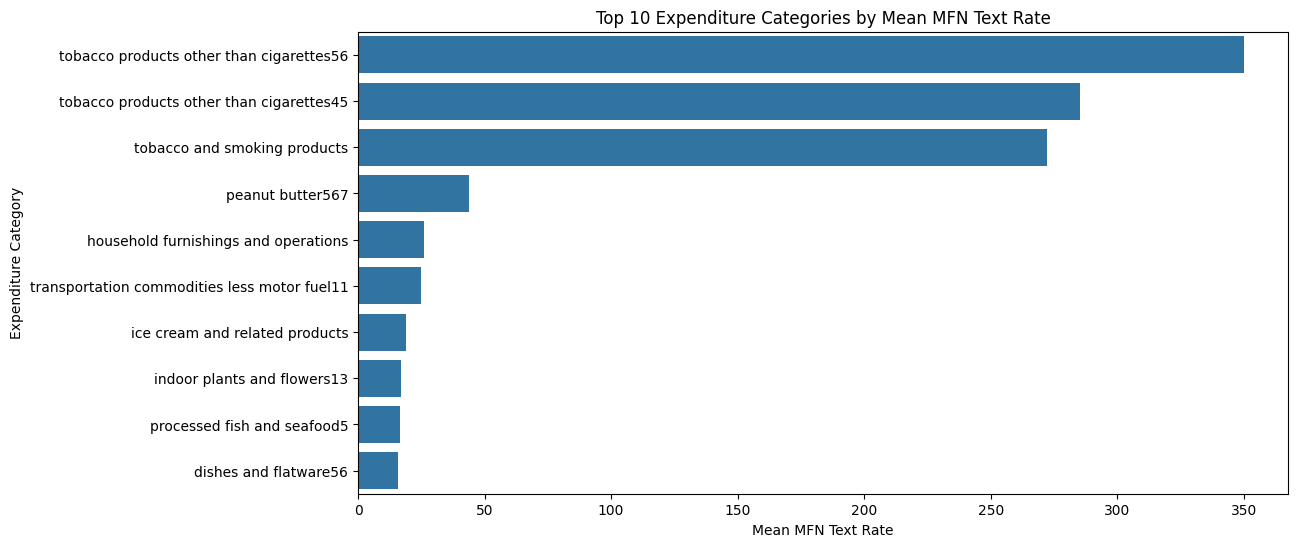

In [ ]:
# Top 10 expenditure categories by mean mfn_text_rate_mean
top_text_rates = final_tariff_mean_df.groupby('expenditure_category')['mfn_text_rate_mean'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_text_rates.values, y=top_text_rates.index)
plt.xlabel('Mean MFN Text Rate')
plt.ylabel('Expenditure Category')
plt.title('Top 10 Expenditure Categories by Mean MFN Text Rate')
plt.show()


2. CPI Percentage Change Heatmap for top 25 consumer categories over Time




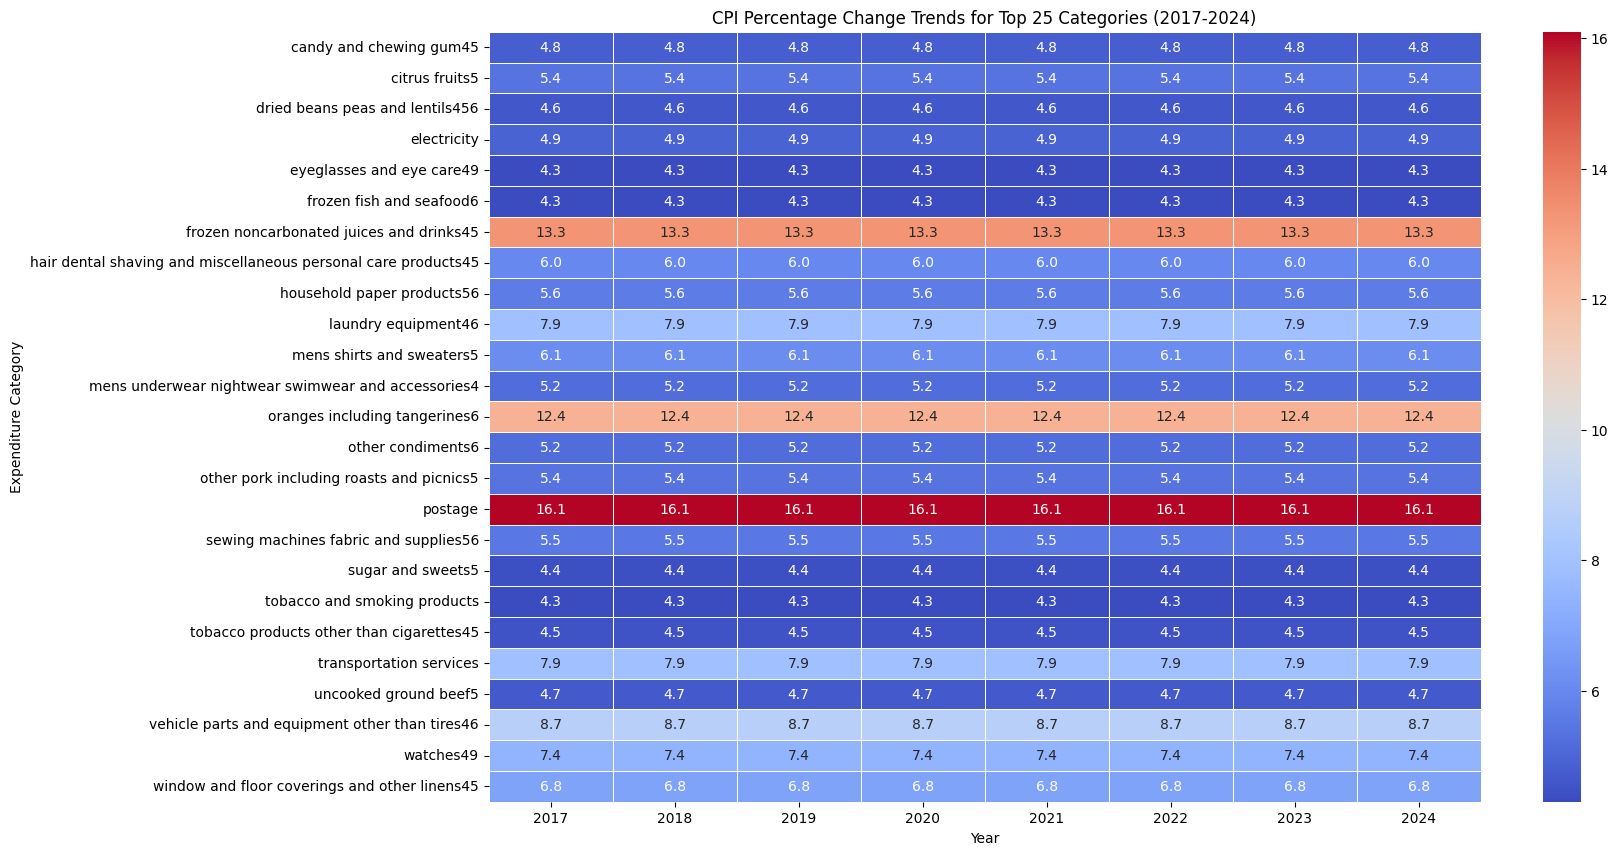

In [ ]:
# Ensure cpi_percentage_change is numeric
final_tariff_mean_df['cpi_percentage_change'] = pd.to_numeric(final_tariff_mean_df['cpi_percentage_change'], errors='coerce')

# Calculate the mean cpi_percentage_change for each category across all years
mean_cpi_change = final_tariff_mean_df.groupby('expenditure_category')['cpi_percentage_change'].mean().reset_index()

# Select the top 25 categories based on mean cpi_percentage_change
top_25_categories = mean_cpi_change.nlargest(25, 'cpi_percentage_change')['expenditure_category']

# Filter the original DataFrame to include only the top 25 categories
filtered_df = final_tariff_mean_df[final_tariff_mean_df['expenditure_category'].isin(top_25_categories)]

# Create a pivot table to track CPI percentage change over the years for the top 25 categories
cpi_trend_pivot = filtered_df.pivot_table(index='expenditure_category', columns='Year', values='cpi_percentage_change')

# Plot the data
plt.figure(figsize=(16, 10))
sns.heatmap(cpi_trend_pivot, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5)
plt.title('CPI Percentage Change Trends for Top 25 Categories (2017-2024)')
plt.xlabel('Year')
plt.ylabel('Expenditure Category')
plt.show()


3. Top 10 expenditure categories based on their average CPI percentage change.

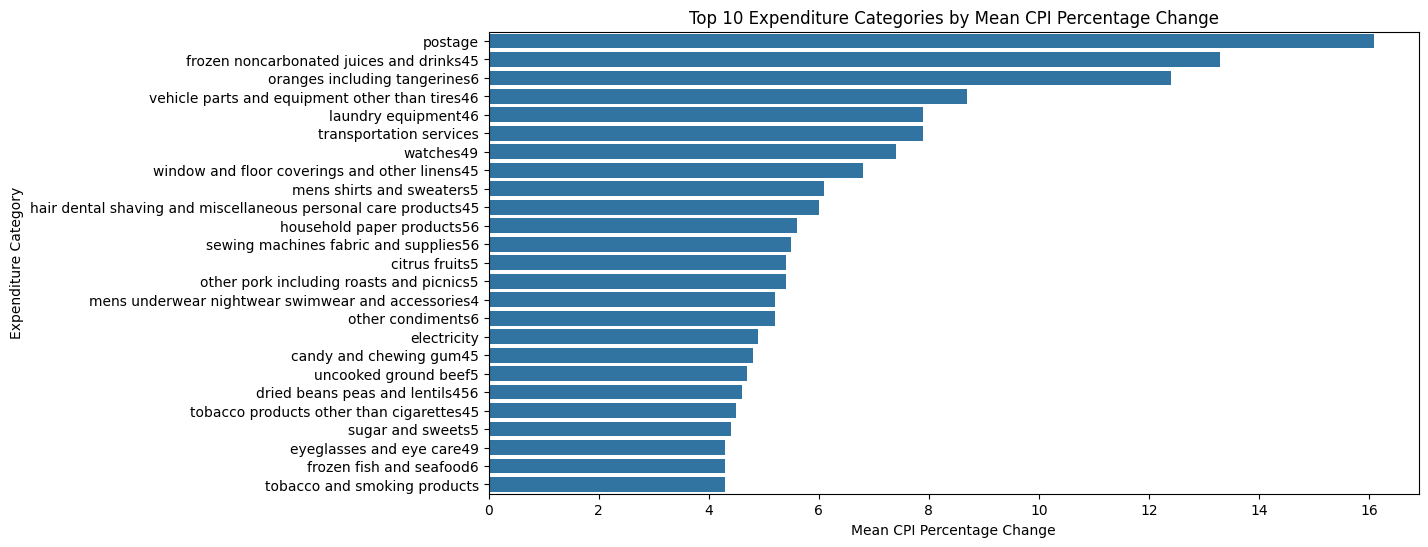

In [ ]:
# Ensure cpi_percentage_change is numeric
final_tariff_mean_df['cpi_percentage_change'] = pd.to_numeric(final_tariff_mean_df['cpi_percentage_change'], errors='coerce')

# Calculate the mean cpi_percentage_change for each category across all years
mean_cpi_change = final_tariff_mean_df.groupby('expenditure_category')['cpi_percentage_change'].mean().nlargest(25)

# Plot the top 10 expenditure categories by mean CPI percentage change
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_cpi_change.values, y=mean_cpi_change.index)
plt.xlabel('Mean CPI Percentage Change')
plt.ylabel('Expenditure Category')
plt.title('Top 10 Expenditure Categories by Mean CPI Percentage Change')
plt.show()


In [ ]:
# Generate summary statistics
print(cpi_df.head())


0  Year Indent Level         Expenditure category CPI Percentage Change
0  2017            0                    all items                   1.9
1  2017            1                         food                   1.3
2  2017            2                 food at home                   0.7
3  2017            3  cereals and bakery products                  -0.8
4  2017            4  cereals and cereal products                  -2.2


# Data Clean up for cpi_df

In [ ]:
# Remove non-numeric characters from 'CPI Percentage Change'
cpi_df['CPI Percentage Change'] = cpi_df['CPI Percentage Change'].str.replace(r'[^0-9.-]', '', regex=True)

# Convert 'CPI Percentage Change' to numeric
cpi_df['CPI Percentage Change'] = pd.to_numeric(cpi_df['CPI Percentage Change'], errors='coerce')

# Drop rows with NaN values in 'CPI Percentage Change'
cpi_df = cpi_df.dropna(subset=['CPI Percentage Change'])

# Check for any remaining missing values
print(cpi_df.isnull().sum())


0
Year                     0
Indent Level             0
Expenditure category     0
CPI Percentage Change    0
dtype: int64


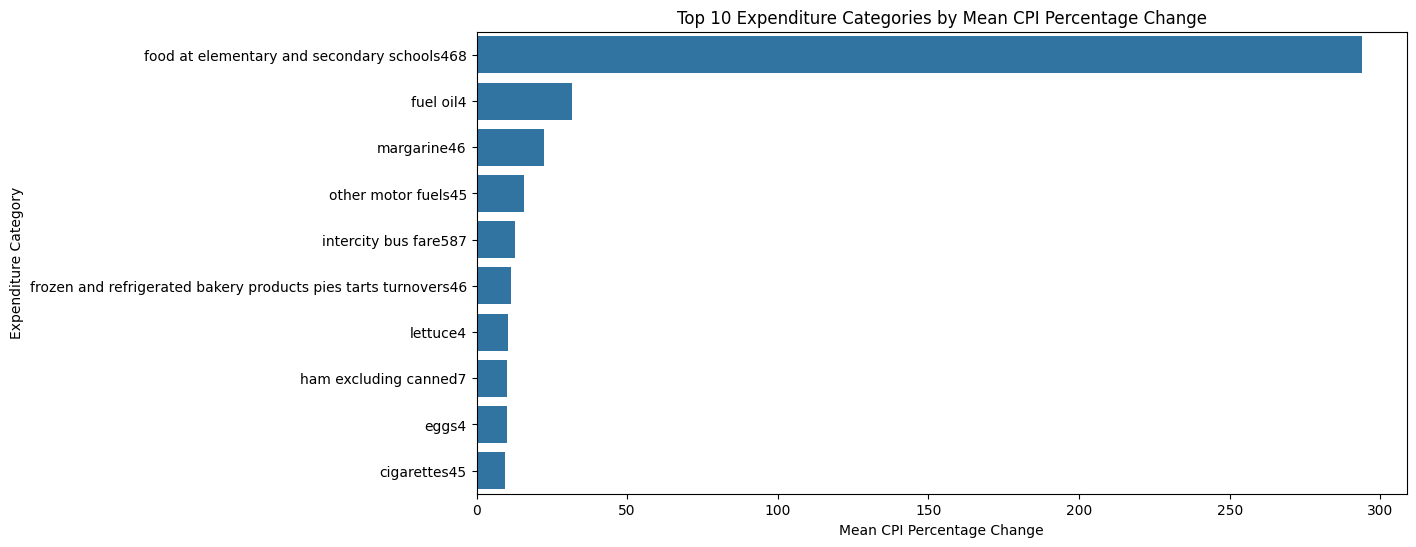

In [ ]:
# Top 10 expenditure categories by mean CPI Percentage Change
top_cpi_changes = cpi_df.groupby('Expenditure category')['CPI Percentage Change'].mean().nlargest(10)

# Plot the top 10 categories
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cpi_changes.values, y=top_cpi_changes.index)
plt.xlabel('Mean CPI Percentage Change')
plt.ylabel('Expenditure Category')
plt.title('Top 10 Expenditure Categories by Mean CPI Percentage Change')
plt.show()


# CPI Trends Over Time

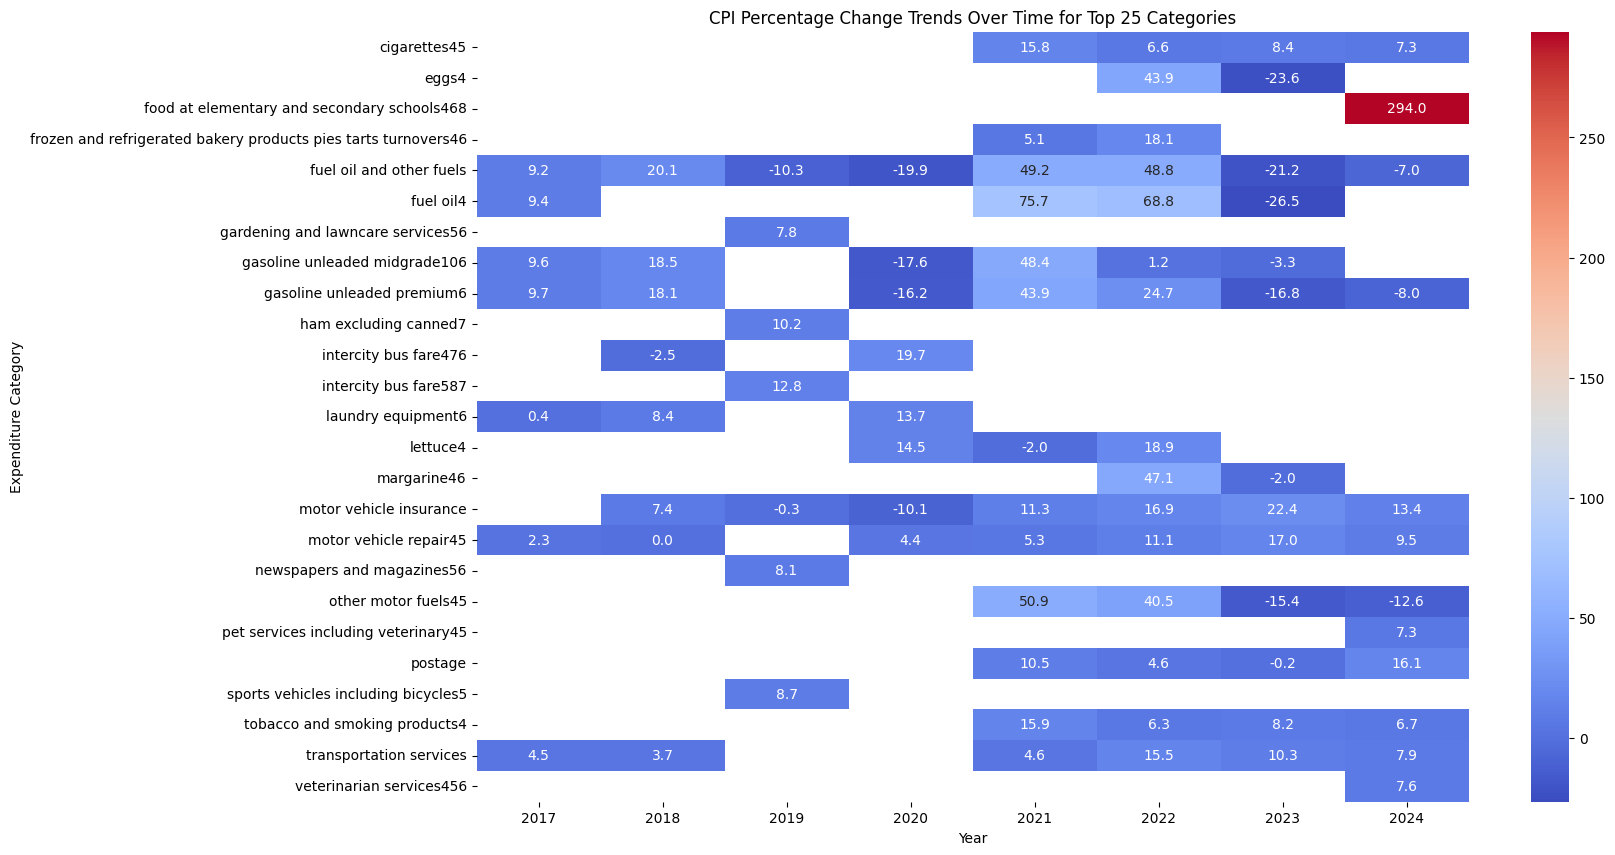

In [ ]:
# Calculate the mean CPI percentage change for each category
mean_cpi_change = cpi_df.groupby('Expenditure category')['CPI Percentage Change'].mean().reset_index()

# Select the top 25 categories based on mean CPI percentage change
top_25_categories = mean_cpi_change.nlargest(25, 'CPI Percentage Change')['Expenditure category']

# Filter the original DataFrame to include only the top 25 categories
filtered_cpi_df = cpi_df[cpi_df['Expenditure category'].isin(top_25_categories)]

# Pivot table to get years as columns and expenditure categories as rows for the top 25 categories
cpi_trend_pivot = filtered_cpi_df.pivot(index='Expenditure category', columns='Year', values='CPI Percentage Change')

# Plot the heatmap for CPI trends over time for the top 25 categories
plt.figure(figsize=(16, 10))
sns.heatmap(cpi_trend_pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('CPI Percentage Change Trends Over Time for Top 25 Categories')
plt.ylabel('Expenditure Category')
plt.xlabel('Year')
plt.show()


# Trend for "Energy Commodities" on CPI percentage change using both final_tariff_mean_df and cpi_df

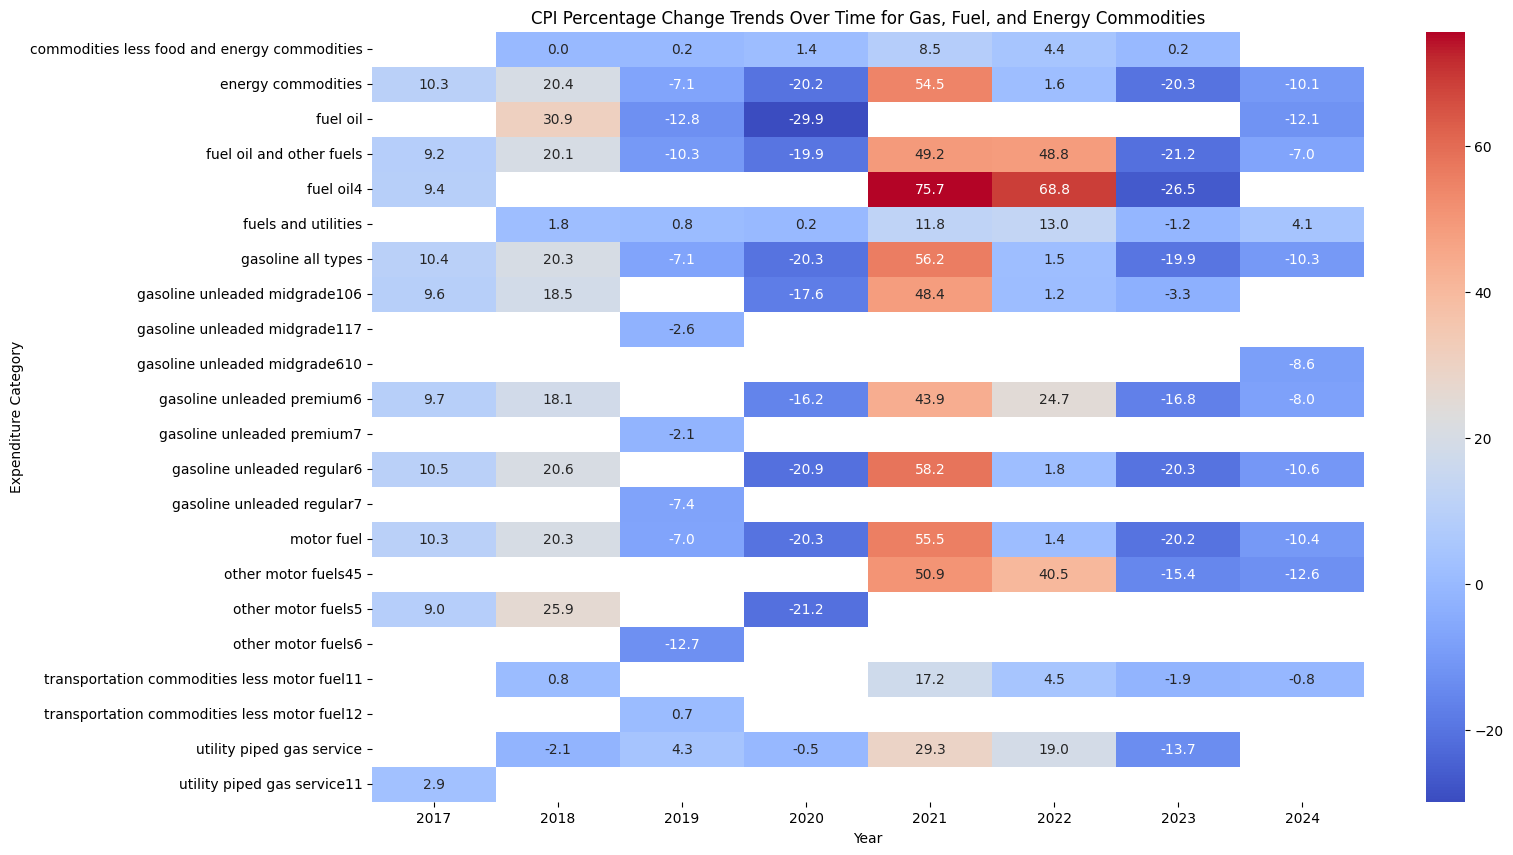

In [ ]:
# Define the keywords to filter data
keywords = ['energy commodities', 'gas', 'fuel']

# Filter data for keywords in cpi_df
cpi_filtered = cpi_df[cpi_df['Expenditure category'].str.contains('|'.join(keywords), case=False)]

# Pivot table to get years as columns and expenditure categories as rows for the filtered categories
cpi_trend_pivot = cpi_filtered.pivot(index='Expenditure category', columns='Year', values='CPI Percentage Change')

# Plot the heatmap for CPI trends over time for the filtered categories
plt.figure(figsize=(16, 10))
sns.heatmap(cpi_trend_pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('CPI Percentage Change Trends Over Time for Gas, Fuel, and Energy Commodities')
plt.ylabel('Expenditure Category')
plt.xlabel('Year')
plt.show()


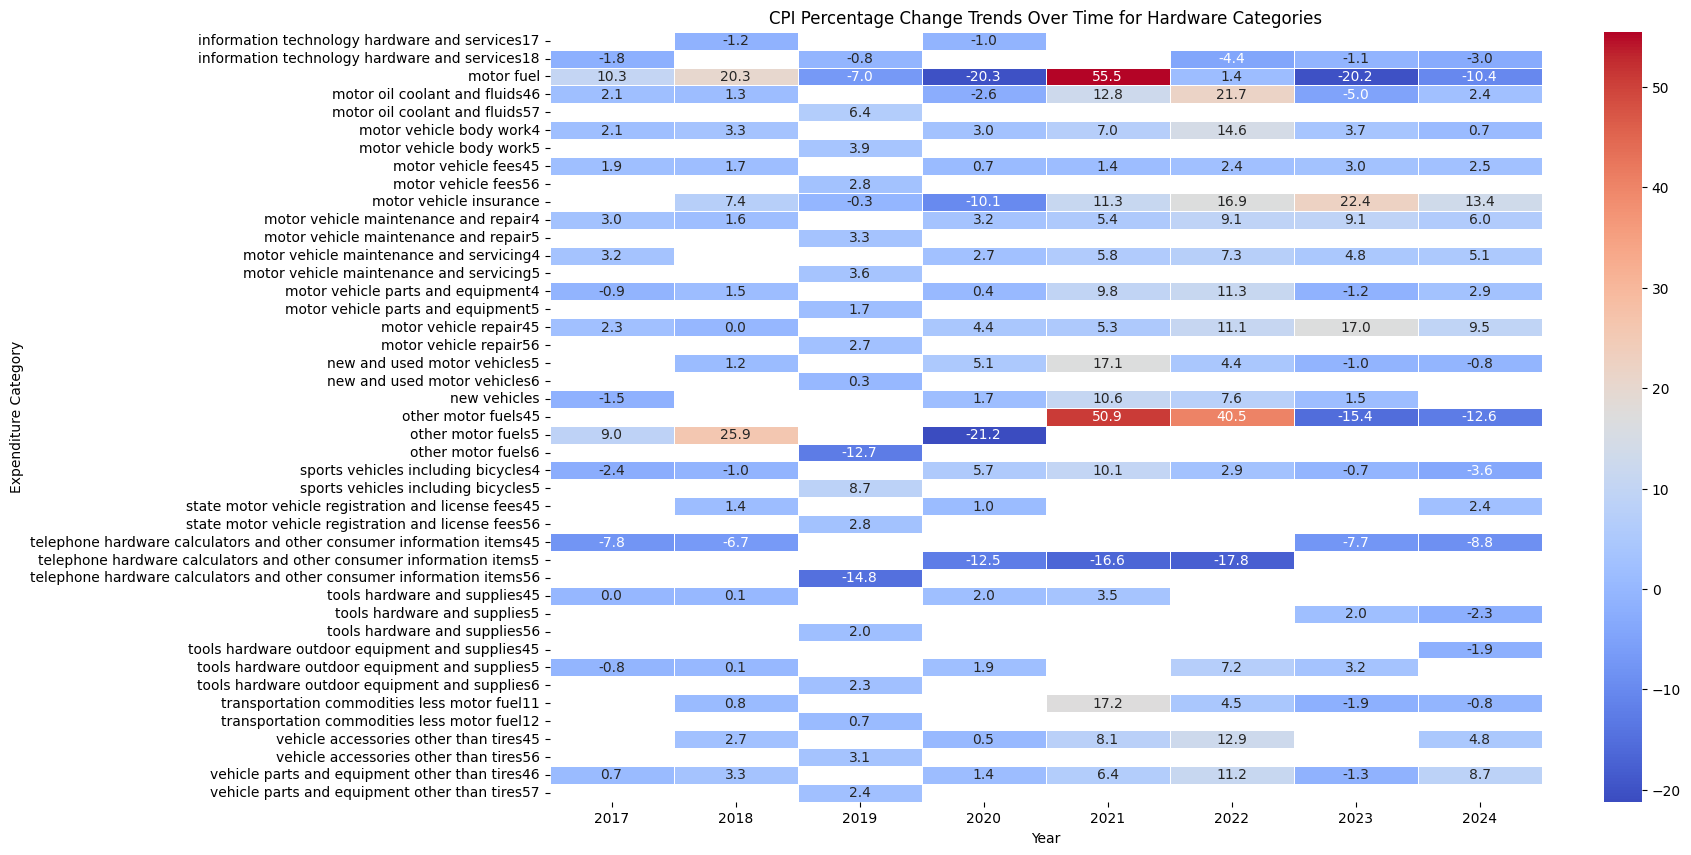

In [ ]:
# Define the keywords to filter data
keywords_include = ['motor', 'vehicle', 'hardware', 'parts']
keywords_exclude = ['chicken']

# Filter data for keywords to include
cpi_filtered = cpi_df[cpi_df['Expenditure category'].str.contains('|'.join(keywords_include), case=False)]

# Exclude categories that match the keyword 'chicken'
cpi_filtered = cpi_filtered[~cpi_filtered['Expenditure category'].str.contains('|'.join(keywords_exclude), case=False)]

# Pivot table to get years as columns and expenditure categories as rows for the filtered categories
cpi_trend_pivot = cpi_filtered.pivot(index='Expenditure category', columns='Year', values='CPI Percentage Change')

# Plot the heatmap for CPI trends over time for the filtered categories
plt.figure(figsize=(16, 10))
sns.heatmap(cpi_trend_pivot, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5)
plt.title('CPI Percentage Change Trends Over Time for Hardware Categories')
plt.ylabel('Expenditure Category')
plt.xlabel('Year')
plt.show()




In [ ]:
#PERFORM AND EXPLAIN YOUR EXPLORATORY ANALYSIS IN THIS SECTION

# Step 3:  Identify 3 research questions and perform analysis


Since CPI changes are very broad across categories, we will zero down on specific consumer category for the scope of this analysis.

Top 3 Questions we want to find out from this data set and analysis is carried as part of interpretation of plot result:


1. How do changes in MFN (Most-Favored-Nation) text rates influence the CPI percentage change for categories related to motor, vehicle, hardware, and parts over time?

2. Are certain expenditure categories (like motor, vehicle, hardware, and parts) more sensitive to changes in tariff rates than others, and how is this reflected in their CPI percentage change?

3. What temporal patterns and trends can be observed in both MFN text rates and CPI percentage changes over the years for the selected categories

# Q1. How do changes in MFN (Most-Favored-Nation) text rates influence the CPI percentage change for categories related to motor, vehicle, hardware, and parts over time?

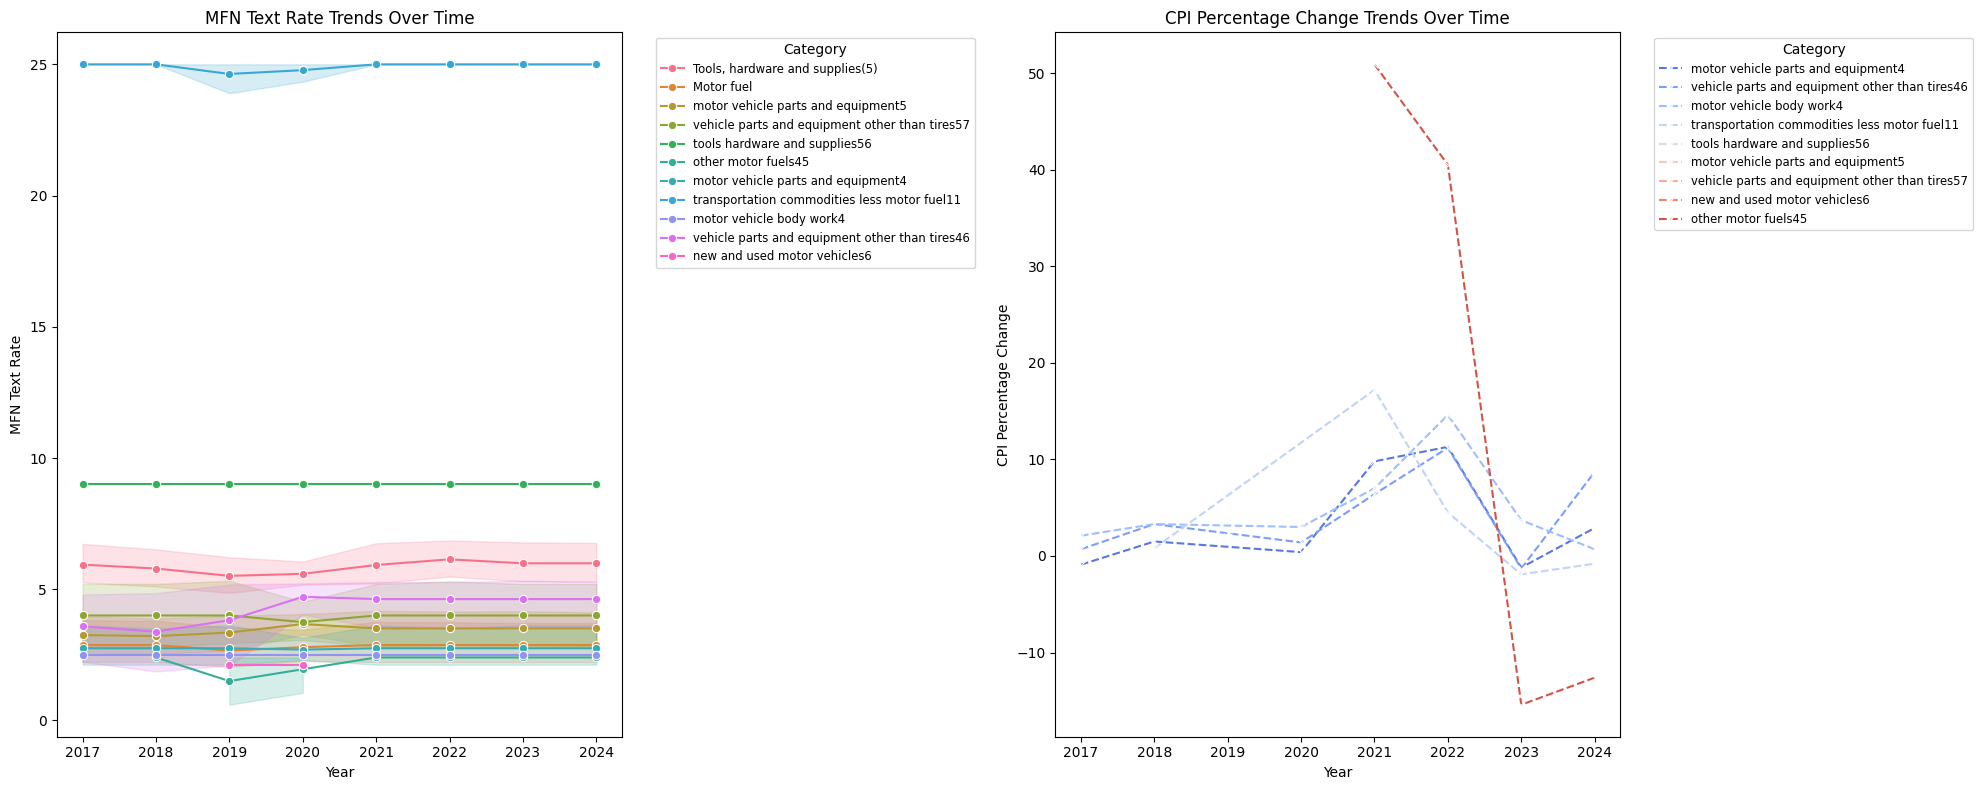

In [ ]:
# Define the keywords to filter data
keywords_include = ['motor', 'vehicle', 'hardware', 'parts']
keywords_exclude = ['chicken']

# Filter data for keywords to include in "Matched Expenditure category"
tariff_filtered = tariff_df[tariff_df['Matched Expenditure category'].str.contains('|'.join(keywords_include), case=False)]
tariff_filtered = tariff_filtered[~tariff_filtered['Matched Expenditure category'].str.contains('|'.join(keywords_exclude), case=False)]

# Use the same categories for filtering cpi_df
matched_categories = tariff_filtered['Matched Expenditure category'].unique()
cpi_filtered = cpi_df[cpi_df['Expenditure category'].isin(matched_categories)]

# Set up the figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the MFN Text Rate
sns.lineplot(data=tariff_filtered, x='Year', y='mfn_text_rate', hue='Matched Expenditure category', ax=axes[0], marker='o')
axes[0].set_title('MFN Text Rate Trends Over Time')
axes[0].set_ylabel('MFN Text Rate')
axes[0].set_xlabel('Year')
axes[0].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='medium')

# Plot the CPI Percentage Change
sns.lineplot(data=cpi_filtered, x='Year', y='CPI Percentage Change', hue='Expenditure category', ax=axes[1], marker='x', linestyle='--', palette='coolwarm')
axes[1].set_title('CPI Percentage Change Trends Over Time')
axes[1].set_ylabel('CPI Percentage Change')
axes[1].set_xlabel('Year')
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='medium')

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# Analysis for Q1:
Left Plot: MFN Text Rate Trends Over Time

1. Consistent Trends: MFN text rates remain relatively stable across all categories from 2017 to 2024.

2. Higher MFN Rates: Categories like "Tools, hardware, and supplies" have consistently higher MFN text rates, approximately 25%, showing that these items have been consistently protected with high tariff rates.

3. Lower MFN Rates: Categories such as "Motor fuel" and "New and used motor vehicles" remain at lower tariff rates (around 5% or below), indicating minimal trade protection in these areas.

4. Small Variations: There is a slight dip in 2019-2020 for several categories, likely reflecting trade policy adjustments or macroeconomic conditions during that time.

Right Plot: CPI Percentage Change Trends Over Time

1. Dynamic Changes in CPI: The CPI percentage changes exhibit greater fluctuations compared to MFN rates, reflecting the impact of external factors like supply chain disruptions, inflationary pressures, or policy changes.

2. Sharp Decline Post-2022: A category such as "Motor vehicle body work" demonstrates a steep decline in CPI percentage change after 2022. This sharp decrease could be attributed to stabilization in supply chains, changes in consumer demand, or tariff policy shifts.

3. General Upward Trends: For other categories like "Tools hardware and supplies" or "Transportation commodities less motor fuel," CPI changes remain positive or increase moderately over time, suggesting consistent price growth.






# Q2. Are certain expenditure categories (like motor, vehicle, hardware, and parts) more sensitive to changes in tariff rates than others, and how is this reflected in their CPI percentage change?

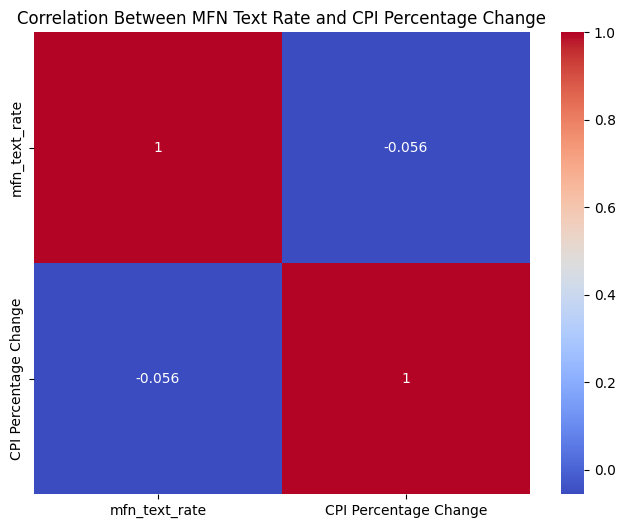

In [ ]:
# Merge the two datasets on Year and Matched Expenditure category
merged_df = pd.merge(tariff_filtered, cpi_filtered, left_on=['Year', 'Matched Expenditure category'], right_on=['Year', 'Expenditure category'])

# Calculate Correlations
correlation_matrix = merged_df[['mfn_text_rate', 'CPI Percentage Change']].corr()

# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between MFN Text Rate and CPI Percentage Change')
plt.show()


# Analysis for Q2:

The heatmap presents the correlation between the MFN (Most-Favored-Nation) text rate and the CPI (Consumer Price Index) percentage change. It uses a color gradient from blue to red, where blue indicates a negative correlation and red indicates a positive correlation.

Key Observations:
Perfect Positive Correlation Within Categories:

  * The correlation between mfn_text_rate and itself is 1.0, indicating a perfect positive correlation.

  * The correlation between CPI Percentage Change and itself is also 1.0, reflecting a perfect positive correlation.

Very Weak Negative Correlation:

  * The correlation between mfn_text_rate and CPI Percentage Change is -0.056, which indicates a very weak negative correlation.

  * This weak negative correlation suggests that there is minimal, almost negligible, inverse relationship between MFN text rates and CPI percentage changes.

Conclusion:

1. Stability in MFN Text Rates: The perfect positive correlation within mfn_text_rate indicates that the tariff rates remain stable over time for each category.

2. Minimal Impact on CPI: The very weak negative correlation between mfn_text_rate and CPI Percentage Change suggests that changes in MFN text rates do not have a significant impact on consumer prices for the selected categories. This implies that other factors might be more influential in determining the CPI percentage changes.



Q3. What temporal patterns and trends can be observed in both MFN text rates and CPI percentage changes over the years for the selected categories

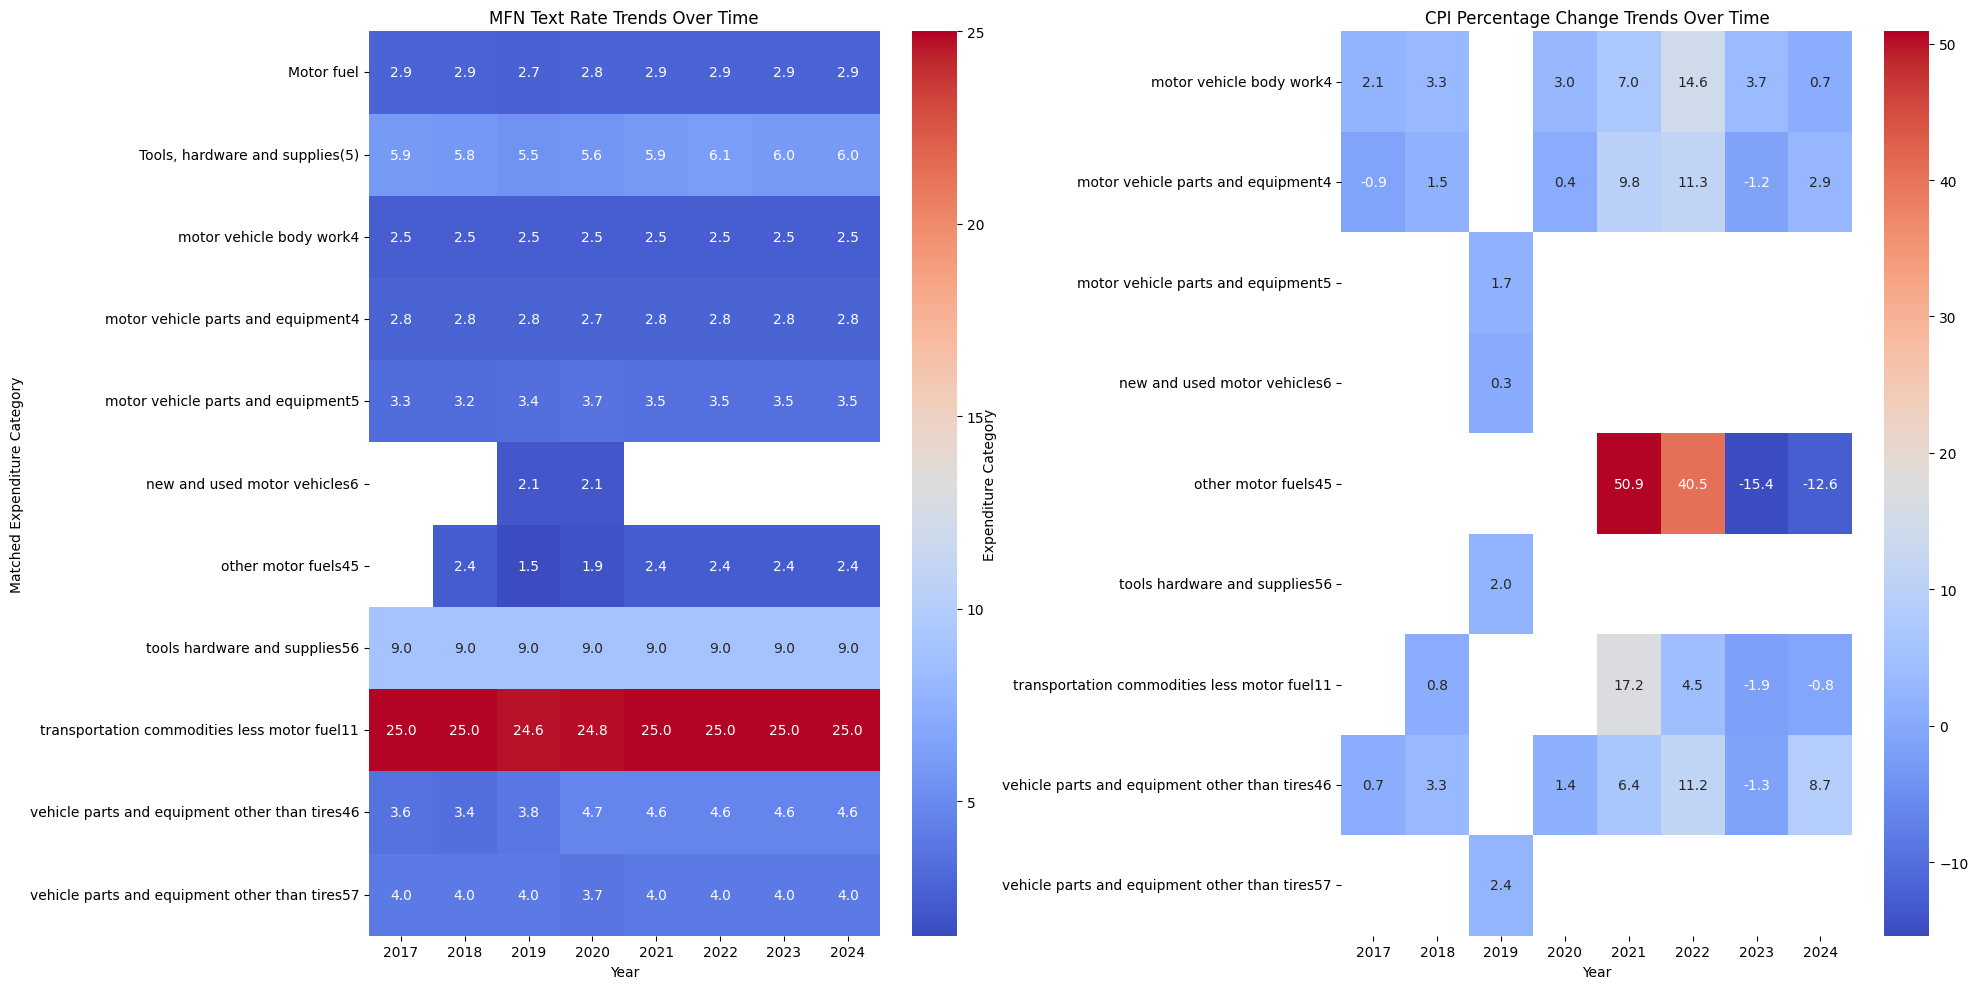

In [ ]:
# Define the keywords to filter data
keywords_include = ['motor', 'vehicle', 'hardware', 'parts']
keywords_exclude = ['chicken']

# Filter data for keywords to include in "Matched Expenditure category"
tariff_filtered = tariff_df[tariff_df['Matched Expenditure category'].str.contains('|'.join(keywords_include), case=False)]
tariff_filtered = tariff_filtered[~tariff_filtered['Matched Expenditure category'].str.contains('|'.join(keywords_exclude), case=False)]

# Use the same categories for filtering cpi_df
matched_categories = tariff_filtered['Matched Expenditure category'].unique()
cpi_filtered = cpi_df[cpi_df['Expenditure category'].isin(matched_categories)]

# Aggregate data to avoid duplicates
tariff_aggregated = tariff_filtered.groupby(['Year', 'Matched Expenditure category'])['mfn_text_rate'].mean().reset_index()
cpi_aggregated = cpi_filtered.groupby(['Year', 'Expenditure category'])['CPI Percentage Change'].mean().reset_index()

# Create Pivot Tables
tariff_pivot = tariff_aggregated.pivot(index='Matched Expenditure category', columns='Year', values='mfn_text_rate')
cpi_pivot = cpi_aggregated.pivot(index='Expenditure category', columns='Year', values='CPI Percentage Change')

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for MFN Text Rate
sns.heatmap(tariff_pivot, annot=True, fmt=".1f", cmap='coolwarm', ax=axes[0])
axes[0].set_title('MFN Text Rate Trends Over Time')
axes[0].set_ylabel('Matched Expenditure Category')
axes[0].set_xlabel('Year')

# Heatmap for CPI Percentage Change
sns.heatmap(cpi_pivot, annot=True, fmt=".1f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('CPI Percentage Change Trends Over Time')
axes[1].set_ylabel('Expenditure Category')
axes[1].set_xlabel('Year')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Q3 Analysis

The plot consists of two heatmaps displaying trends in MFN Text Rate (left) and CPI Percentage Change (right) over time for various expenditure categories.


MFN Text Rate Trends Over Time (Left Heatmap)


1. "Transportation commodities less motor fuel" consistently has the highest MFN text rate (25%) across all years, indicating a stable and high tariff on this category.
2. Other categories, such as "tools hardware and supplies", "motor vehicle parts and equipment", and "tools, hardware, and supplies", show lower and more stable MFN text rates, typically below 10%.
3. Minor variations in MFN text rates are observed over time, but overall, most categories remain stable.
Implications:

4. The stability in MFN text rates suggests consistent tariff policies over the years for most expenditure categories.
5. Higher MFN text rates in categories like transportation commodities likely contribute to higher costs for these goods but need to be correlated with CPI to confirm.

CPI Percentage Change Trends Over Time (Right Heatmap)


1. Significant volatility is observed in CPI percentage changes:
2. "Other motor fuels" shows a sharp increase in CPI in 2019 (+50.9%) and 2020 (+40.5%) but a drastic decrease in 2022 (-15.4%) and 2023 (-12.6%).
3. Categories like "transportation commodities" and "vehicle parts and equipment other than tires" also display notable fluctuations over the years.
4. Categories such as "tools hardware and supplies" and "new and used motor vehicles" exhibit relatively stable CPI percentage changes with minor variations

5. Some categories (e.g., "motor vehicle body work") show a gradual increase in CPI percentage changes over time.


Conclusion:

No Direct Correlation Between MFN Text Rates and CPI Changes:

Despite high and stable MFN text rates for certain categories (e.g., "transportation commodities"), corresponding CPI percentage changes are not consistently high, suggesting other factors are driving CPI fluctuations.
Categories with low MFN text rates (e.g., "tools hardware and supplies") also show minor CPI changes, reinforcing the lack of a strong relationship.

Volatile CPI Categories:

"Other motor fuels" and "transportation commodities" exhibit dramatic CPI changes, potentially linked to external market forces like fuel price fluctuations and global trade conditions.

Policy Implication:

Tariff policies (MFN text rates) may not be the primary driver of consumer price inflation (CPI) in most categories.
Further analysis could focus on external economic factors, such as commodity prices, supply chain disruptions, or domestic policies.

In [ ]:
#OVERVIEW YOUR QUESTION AND PERFORM YOUR ANALYSIS IN THIS SECTION

# Step 4:  Conclusion

1. No Direct Correlation Between MFN Text Rates and CPI Changes:

  * Despite high and stable MFN text rates for certain categories (e.g., "transportation commodities"), corresponding CPI percentage changes are not consistently high, suggesting other factors are driving CPI fluctuations.
  * Categories with low MFN text rates (e.g., "tools hardware and supplies") also show minor CPI changes, reinforcing the lack of a strong relationship.

2. Volatile CPI Categories:

  * "Other motor fuels" and "transportation commodities" exhibit dramatic CPI changes, potentially linked to external market forces like fuel price fluctuations and global trade conditions.

3. Policy Implication:

  * Tariff policies (MFN text rates) may not be the primary driver of consumer price inflation (CPI) in most categories.



In [ ]:
#EXPAND THIS SECTION TO PRESENT YOUR FINDINGS

# 2. Video

Make a video where you go over each part of the report speaking about the steps you undertook and explaining your work, reasonings, insights and highlighting the important points of the project. You do not need to explain the lines of code (unless you feel it is required).

1. The video should be more than 5 minutes and strictly less than 10 minutes.
2. Both audio and video is required.
3. You can use the zoom to record the video. Start a meeting, start video, start recording and share screen.
4. Make sure your audio is clear before uploading the video to the gradescope.


Additionally (and this is important), ensure you follow the format the video submission. If one of these criteria is missing, we will not grade the video.
* Show some form of ID at the start of the video so we know who you are.
* Show your code in the video by screensharing.
* Show your face in the video.


In [ ]:
https://drive.google.com/file/d/1ybxi8UXXOw5tYkIzhsH4x68_mUJMf7t7/view?usp=sharing